In [1]:
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

from tqdm.notebook import tqdm as tqdm_notebook
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Define data root directory
data_dir = "./data/After Filters"
print(os.listdir(data_dir))

['gasto_energia.csv']


In [3]:
def move_sliding_window(data, window_size, inputs_cols_indices, label_col_index):
    """
    data: numpy array including data
    window_size: size of window
    inputs_cols_indices: col indices to include
    """

    # (# instances created by movement, seq_len (timestamps), # features (input_len))
    inputs = np.zeros((len(data) - window_size, window_size, len(inputs_cols_indices)))
    labels = np.zeros(len(data) - window_size)

    for i in range(window_size, len(data)):
        inputs[i - window_size] = data[i - window_size : i, inputs_cols_indices]
        labels[i - window_size] = data[i, label_col_index]
    inputs = inputs.reshape(-1, window_size, len(inputs_cols_indices))
    labels = labels.reshape(-1, 1)
    print(inputs.shape, labels.shape)

    return inputs, labels

In [4]:
label_col_index = 0  # consumption as label to predict
inputs_cols_indices = range(5)  # use (consumption, hour, dayofweek, month, dayofyear) columns as features

# Define window_size period and split inputs/labels
window_size = 90

# The scaler objects will be stored in this dictionary so that our output test data from the model can be re-scaled during evaluation
label_scalers = {}

train_x = []
test_x = {}
test_y = {}

# Skipping the files we're not using
processing_files = [file for file in os.listdir(data_dir) if os.path.splitext(file)[1] == ".csv"]

num_files_for_dataset = 5

for file in tqdm_notebook(processing_files[:num_files_for_dataset]):
  print(f"Processing {file} ...")
  # Store csv file in a Pandas DataFrame
  df = pd.read_csv(os.path.join(data_dir, file), parse_dates=["Datetime"])
  print(df)

  # Processing the time data into suitable input formats
  df["hour"] = df.apply(lambda x: x["Datetime"].hour, axis=1)
  df["dayofweek"] = df.apply(lambda x: x["Datetime"].dayofweek, axis=1)
  df["month"] = df.apply(lambda x: x["Datetime"].month, axis=1)
  df["dayofyear"] = df.apply(lambda x: x["Datetime"].dayofyear, axis=1)
  df = df.sort_values("Datetime").drop("Datetime", axis=1)
  # df = df.drop("Time", axis=1)

  # Scaling the input data
  sc = MinMaxScaler()
  label_sc = MinMaxScaler()
  data = sc.fit_transform(df.values)

  # Obtaining the scaler for the labels(usage data) so that output can be
  # re-scaled to actual value during evaluation
  label_sc.fit(df.iloc[:, label_col_index].values.reshape(-1, 1))
  label_scalers[file] = label_sc

  # Move the window
  inputs, labels = move_sliding_window(
    data,
    window_size,
    inputs_cols_indices=inputs_cols_indices,
    label_col_index=label_col_index,
  )

  # CONCAT created instances from all .csv files.
  # Split data into train/test portions and combining all data from different files into a single array
  test_portion = int(0.1 * len(inputs))
  if len(train_x) == 0:  # first iteration
    train_x = inputs[:-test_portion]
    train_y = labels[:-test_portion]
  else:
    train_x = np.concatenate((train_x, inputs[:-test_portion]))
    train_y = np.concatenate((train_y, labels[:-test_portion]))
  test_x[file] = inputs[-test_portion:]
  test_y[file] = labels[-test_portion:]

  0%|          | 0/1 [00:00<?, ?it/s]

Processing gasto_energia.csv ...
       Datetime         MWh
0    1999-01-01  109.748880
1    1999-01-02  118.837920
2    1999-01-03  117.299040
3    1999-01-04  152.296320
4    1999-01-05  153.918480
...         ...         ...
8761 2022-12-27  279.059467
8762 2022-12-28  264.907205
8763 2022-12-29  255.616802
8764 2022-12-30  257.337626
8765 2022-12-31  245.716996

[8766 rows x 2 columns]
(8676, 90, 5) (8676, 1)


In [5]:
batch_size = 1024

train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))

# Drop the last incomplete batch
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)

In [6]:
print(f"Train Size: {train_x.shape}, Batch Size: {batch_size}, # of iterations per epoch: {int(train_x.shape[0]/batch_size)}")

Train Size: (7809, 90, 5), Batch Size: 1024, # of iterations per epoch: 7


In [7]:
# release some memory
del train_x, train_y

In [8]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("CPU is available")

CPU is available


In [9]:
class GRUNet(nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim, n_layers, drop_prob=0.2):
    super(GRUNet, self).__init__()
    self.hidden_dim = hidden_dim
    self.n_layers = n_layers

    self.gru = nn.GRU(
      input_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob
    )
    self.fc = nn.Linear(hidden_dim, output_dim)
    self.relu = nn.ReLU()

  def forward(self, x, h):
    out, h = self.gru(x, h)
    # print(out[:, -1].shape, h.shape)
    # select hidden state of last timestamp (t=90) (1024, 256)
    out = self.fc(self.relu(out[:, -1]))  # out[:, -1, :]
    # print(out.shape) # (1024, 1)
    return out, h

  def init_hidden(self, batch_size):
    # Initialze h_0 with zeros
    weight = next(self.parameters()).data
    hidden = (
        weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device)
    )
    return hidden


class LSTMNet(nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim, n_layers, drop_prob=0.2):
    super(LSTMNet, self).__init__()
    self.hidden_dim = hidden_dim
    self.n_layers = n_layers

    self.lstm = nn.LSTM(input_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob)
    self.fc = nn.Linear(hidden_dim, output_dim)
    self.relu = nn.ReLU()

  def forward(self, x, h):
    out, h = self.lstm(x, h)
    out = self.fc(self.relu(out[:, -1]))
    return out, h

  def init_hidden(self, batch_size):
    weight = next(self.parameters()).data
    # Initialze h_0, c_0 with zeros
    hidden = (
      weight.new(self.n_layers, batch_size, self.hidden_dim)
      .zero_()
      .to(device),  # h_0
      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
    )
    return hidden

In [10]:
def train(
    train_loader,
    learn_rate,
    hidden_dim=256,
    n_layers=2,
    n_epochs=5,
    model_type="GRU",
    print_every=100,
):

  input_dim = next(iter(train_loader))[0].shape[2]  # 5

  # Batch generator (train_data, train_label)
  # print(next(iter(train_loader))[0].shape, next(iter(train_loader))[1].shape) # torch.Size([1024, 90, 5]) torch.Size([1024, 1])

  output_dim = 1

  # Instantiating the models
  if model_type == "GRU":
    model = GRUNet(input_dim, hidden_dim, output_dim, n_layers)
  else:
    model = LSTMNet(input_dim, hidden_dim, output_dim, n_layers)
  model.to(device)

  # Defining loss function and optimizer
  criterion = nn.MSELoss()  # Mean Squared Error
  optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)

  model.train()
  print("Starting Training of {} model".format(model_type))
  epoch_times = []

  # Start training loop
  for epoch in range(1, n_epochs + 1):
    start_time = time.process_time()
    h = model.init_hidden(batch_size)
    avg_loss = 0.0
    counter = 0
    for x, label in train_loader:
      counter += 1
      if model_type == "GRU":
        h = h.data
      # Unpcak both h_0 and c_0
      elif model_type == "LSTM":
        h = tuple([e.data for e in h])

      # Set the gradients to zero before starting to do backpropragation because
      # PyTorch accumulates the gradients on subsequent backward passes
      model.zero_grad()

      out, h = model(x.to(device).float(), h)
      loss = criterion(out, label.to(device).float())

      # Perform backpropragation
      loss.backward()
      optimizer.step()

      avg_loss += loss.item()
      if counter % print_every == 0:
        print(f"Epoch {epoch} - Step: {counter}/{len(train_loader)} - Average Loss for Epoch: {avg_loss/counter}")
    current_time = time.process_time()

    print(f"Epoch {epoch}/{n_epochs} Done, Total Loss: {avg_loss/len(train_loader)}")

    print(f"Time Elapsed for Epoch: {current_time-start_time} seconds")

    epoch_times.append(current_time - start_time)

  print(f"Total Training Time: {sum(epoch_times)} seconds")
  return model

In [11]:
# seq_len = 90  # (timestamps)
n_hidden = 256
n_layers = 2
n_epochs = 10  # Trocar para 200, pois se estabiliza
print_every = 64
lr = 0.001

In [12]:
gru_model = train(
  train_loader,
  learn_rate=lr,
  hidden_dim=n_hidden,
  n_layers=n_layers,
  n_epochs=n_epochs,
  model_type="GRU",
  print_every=print_every,
)

Starting Training of GRU model
Epoch 1/10 Done, Total Loss: nan
Time Elapsed for Epoch: 79.328125 seconds
Epoch 2/10 Done, Total Loss: nan
Time Elapsed for Epoch: 80.890625 seconds
Epoch 3/10 Done, Total Loss: nan
Time Elapsed for Epoch: 80.953125 seconds
Epoch 4/10 Done, Total Loss: nan
Time Elapsed for Epoch: 79.71875 seconds
Epoch 5/10 Done, Total Loss: nan
Time Elapsed for Epoch: 78.375 seconds
Epoch 6/10 Done, Total Loss: nan
Time Elapsed for Epoch: 80.3125 seconds
Epoch 7/10 Done, Total Loss: nan
Time Elapsed for Epoch: 82.21875 seconds
Epoch 8/10 Done, Total Loss: nan
Time Elapsed for Epoch: 79.015625 seconds
Epoch 9/10 Done, Total Loss: nan
Time Elapsed for Epoch: 76.171875 seconds
Epoch 10/10 Done, Total Loss: nan
Time Elapsed for Epoch: 76.140625 seconds
Total Training Time: 793.125 seconds


# FALTA FILTRAR OS DADOS DE "PODER PÚBLICO" E "REVENDA"

In [13]:
torch.save(gru_model.state_dict(), "./models/gru_model.pt")

In [14]:
lstm_model = train(
  train_loader,
  learn_rate=lr,
  hidden_dim=n_hidden,
  n_layers=n_layers,
  n_epochs=n_epochs,
  model_type="LSTM",
  print_every=print_every,
)

Starting Training of LSTM model
Epoch 1/10 Done, Total Loss: nan
Time Elapsed for Epoch: 98.171875 seconds
Epoch 2/10 Done, Total Loss: nan
Time Elapsed for Epoch: 101.421875 seconds
Epoch 3/10 Done, Total Loss: nan
Time Elapsed for Epoch: 97.53125 seconds
Epoch 4/10 Done, Total Loss: nan
Time Elapsed for Epoch: 101.578125 seconds
Epoch 5/10 Done, Total Loss: nan
Time Elapsed for Epoch: 100.203125 seconds
Epoch 6/10 Done, Total Loss: nan
Time Elapsed for Epoch: 100.875 seconds
Epoch 7/10 Done, Total Loss: nan
Time Elapsed for Epoch: 99.53125 seconds
Epoch 8/10 Done, Total Loss: nan
Time Elapsed for Epoch: 100.53125 seconds
Epoch 9/10 Done, Total Loss: nan
Time Elapsed for Epoch: 101.984375 seconds
Epoch 10/10 Done, Total Loss: nan
Time Elapsed for Epoch: 100.96875 seconds
Total Training Time: 1002.796875 seconds


In [15]:
torch.save(lstm_model.state_dict(), "./models/lstm_model.pt")

In [16]:
# move device to cpu for evaluation to avoid GPU memory run
device = "cpu"

In [17]:
hidden_dim = 256
input_dim = 5
output_dim = 1
n_layers = 2
gru_model = GRUNet(input_dim, hidden_dim, output_dim, n_layers)
gru_model.load_state_dict(torch.load("./models/gru_model.pt"))

<All keys matched successfully>

In [18]:
# Move the model to the appropriate device
gru_model.to(device)

GRUNet(
  (gru): GRU(5, 256, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (relu): ReLU()
)

In [19]:
hidden_dim = 256
input_dim = 5
output_dim = 1
n_layers = 2
lstm_model = LSTMNet(input_dim, hidden_dim, output_dim, n_layers)
lstm_model.load_state_dict(torch.load("./models/lstm_model.pt"))

<All keys matched successfully>

In [20]:
lstm_model.to(device)

LSTMNet(
  (lstm): LSTM(5, 256, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (relu): ReLU()
)

In [21]:
def sMAPE(outputs, targets):
  sMAPE = (
    100
    / len(targets)
    * np.sum(np.abs(outputs - targets) / (np.abs(outputs + targets)) / 2)
  )
  return sMAPE

In [22]:
def evaluate(model, test_x, test_y, label_scalers):
  model.eval()
  outputs = []
  targets = []
  start_time = time.process_time()
  # get data of test data for each state
  for file in test_x.keys():
    inputs = torch.from_numpy(np.array(test_x[file]))
    labels = torch.from_numpy(np.array(test_y[file]))

    h = model.init_hidden(inputs.shape[0])

    # predict outputs
    with torch.no_grad():
      out, h = model(inputs.to(device).float(), h)

    outputs.append(
      label_scalers[file]
      .inverse_transform(out.cpu().detach().numpy())
      .reshape(-1)
    )

    targets.append(label_scalers[file].inverse_transform(labels.numpy()).reshape(-1))

  # Merge all files
  concatenated_outputs = np.concatenate(outputs)
  concatenated_targets = np.concatenate(targets)

  print(f"Evaluation Time: {time.process_time()-start_time}")
  print(f"sMAPE: {round(sMAPE(concatenated_outputs, concatenated_targets), 3)}%")

  # list of of targets/outputs for each state
  return outputs, targets, sMAPE

In [23]:
gru_outputs, targets, gru_sMAPE = evaluate(gru_model, test_x, test_y, label_scalers)

Evaluation Time: 3.015625
sMAPE: nan%


In [24]:
lstm_outputs, targets, lstm_sMAPE = evaluate(lstm_model, test_x, test_y, label_scalers)

Evaluation Time: 4.0625
sMAPE: nan%


In [25]:
len(gru_outputs)  # list of predicted output file for each state (each element has a 1d array for that state)

1

In [26]:
states_list = list(test_x.keys())

In [27]:
states_list

['gasto_energia.csv']

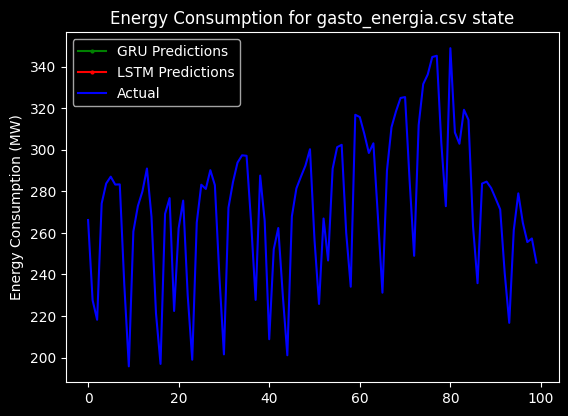

In [28]:
plt.figure(figsize=(14, 10))
plt.subplot(2, 2, 1)
plt.plot(gru_outputs[0][-100:], "-o", color="g", label="GRU Predictions", markersize=2)
plt.plot(lstm_outputs[0][-100:], "-o", color="r", label="LSTM Predictions", markersize=2)
plt.plot(targets[0][-100:], color="b", label="Actual")
plt.ylabel("Energy Consumption (MW)")
plt.title(f"Energy Consumption for {states_list[0]} state")
plt.legend()

# plt.subplot(2, 2, 2)
# plt.plot(gru_outputs[1][-50:], "-o", color="g", label="GRU Predictions", markersize=2)
# plt.plot(lstm_outputs[1][-50:], "-o", color="r", label="LSTM Predictions", markersize=2)
# plt.plot(targets[1][-50:], color="b", label="Actual")
# plt.ylabel("Energy Consumption (MW)")
# plt.title(f"Energy Consumption for {states_list[1]} state")
# plt.legend()

# plt.subplot(2, 2, 3)
# plt.plot(gru_outputs[2][:50], "-o", color="g", label="GRU Predictions", markersize=2)
# plt.plot(lstm_outputs[2][:50], "-o", color="r", label="LSTM Predictions", markersize=2)
# plt.plot(targets[2][:50], color="b", label="Actual")
# plt.ylabel("Energy Consumption (MW)")
# plt.title(f"Energy Consumption for {states_list[2]} state")
# plt.legend()

# plt.subplot(2, 2, 4)
# plt.plot(gru_outputs[3][:100], "-o", color="g", label="GRU Predictions", markersize=2)
# plt.plot(lstm_outputs[3][:100], "-o", color="r", label="LSTM Predictions", markersize=2)
# plt.plot(targets[3][:100], color="b", label="Actual")
# plt.title(f"Energy Consumption for {states_list[3]} state")
# plt.ylabel("Energy Consumption (MW)")
# plt.legend()
# plt.show()